# Problem Set 2

I add code to load the data and the baseline model with investment/market power based on problem set 1.

We will be looking at retail tariffs and solar power. For data on retail rates, see:
- Borenstein, Severin and James B. Bushnell. 2022. "Do Two Electricity Pricing Wrongs Make a Right? Cost Recovery, Externalities, and Efficiency." American Economic Journal: Economic Policy, 14 (4): 80-110.

### Baseline
We will add consumer-side solar panel adoption to the model. We will assume that consumers cannot choose the size of the panels to make things simpler. The first steps will be to clean-up the data to represent consumers choices in a way that is at the right scale.
- To make things easier, we will assume that consumers are not elastic (we take consumption as given), but industrial and commercial users are (note, you will need to add the three demands to the model).
- Residential consumers will face a different price that needs to be high enough to cover the costs of the distribution grid, which are 10 billion annualy. The residential price will be a constant price that covers wholesale costs (price x residential quantity) plus grid costs. While this might seem like a crazy number, California is renowed for passing *all* of the costs of the grid to the retail price (as opposed to having a two-part tariff like many other jurisdictions).
- We will shut off any investment other than solar panels to keep things simple.

Questions:

1. Modify the function to add three demand and compute an adder to the retail tariff. This can be done in two steps, as we did in the retail practice case. What is the equilibrium price in the wholesale market? And the flat retail price? [Note: with inelastic demand and no solar panel adoption, this two step is straightforward for the baseline case]

### Partial equilibrium
You will need to solve the ## households that are chosing to install a panel based on equilibrium prices in the baseline model. In this part, we will ignore the impact that consumers have on prices, so focus on calculating the profit for solar panels only, based on the prices from above.
- To model how many solar plants get build, we will imagine that "q_residential" comes from 12,000,000 households, and we will just divide it by 12 to get it in KWh. As you use the weights (which add up to 8.76), it will get converted into annual MWh, which is convenient as prices are in $/MWh. 
- We will assume that we install a 3 KW installation.
- We will assume that F x 3 is the base cost of the panel. Additionally, each household will draw a random draw that will add to the costs. We can interpret F2 x 3 through these lens.

Questions:

2. Assume that consumers are paid the retail price of electricity for all their solar output. How many households adopt solar panels? [Think about the units here for the answer to make sense in ## households]

3. Assume that consumers are paid the retail price if their solar output coincides with their demand, but the wholesale price otherwise. How does that change the answer?

### Death spiral
You will need to solve for retail prices with solar-adoption effects. Consumers still need to pay for the same grid costs and their net demand of electricity in every period (times the wholesale price).

Questions:

4. Keeping wholesale prices fixed to the baseline, compute how retail prices should change for the two cases above. Take into account that consumers cancel their contributions to grid costs any time they get the retail price for their solar outpupt. What are the average costs of electricity for adopters vs. non-adopters in each case?

5. Now allow for equilibrium effects on the wholesale side. How do the results change?

In [1]:
## LIBRARY AND PATH PREP
begin

    using Pkg
    Pkg.add(["DataFrames", "CSV", "JuMP", "HiGHS", "Plots", "Printf"])

    using DataFrames
    using CSV
    using JuMP
    using HiGHS, Ipopt
    using Plots
    using Printf
    using StatsBase

    dirpath = "/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/pset1/"

end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


"/Users/marreguant/Dropbox/TEACHING/GRAD/Econ_498_2023/pset1/"

## Data

In [2]:
## DATA PREP
begin

    dfclust = CSV.read(string(dirpath,"data_jaere_clustered.csv"), DataFrame);

    # Re-scaling -- Note: Already has 8.76 in there!
    dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

    # Here only one demand type to make it easier
    dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

    # Calibrate demand based on elasticities (using 0.1 here as only one final demand)
    elas = [.1, .2, .5, .3];
    dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
    dfclust.a = dfclust.demand .+ dfclust.b .* dfclust.price;  # intercept

    # Calibrate imports (using elas 0.3)
    dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
    dfclust.am = dfclust.imports .- dfclust.bm .* dfclust.price;  # intercept

    dfclust[:, [:demand,:price,:a,:b,:am,:bm]]

    tech = CSV.read(string(dirpath,"data_technology.csv"), DataFrame);
    afactor = (1 - (1 / (1.05^20.0))) / 0.05;
    tech.F = tech.F ./afactor;
    tech.F2 = tech.F2 ./afactor;
    tech

end

7×15 DataFrame
 Row │ techname       heatrate  heatrate2   F         capLB    capUB    new    ⋯
     │ String15       Float64   Float64     Float64   Float64  Float64  Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Hydro/Nuclear  10.0       0.0          0.0       1.0      1.0        0  ⋯
   2 │ Existing 1      6.67199   0.0929123    0.0      11.5     11.5        0
   3 │ Existing 2      9.79412   0.286247     0.0      14.5     14.5        0
   4 │ Existing 3     13.8181   20.5352       0.0       0.578    0.578      0
   5 │ New Gas         6.6       0.0         78.4773    0.0      0.0        1  ⋯
   6 │ Wind            0.0       0.0        100.303     0.0      0.0        1
   7 │ Solar           0.0       0.0        100.303     0.0      0.0        1
                                                               8 columns omitted

## Baseline model -- modify as needed

In [19]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; 
    ng_price = 4.0, theta=1.0, solve_invest=false,
    pretail=145.0, kw = 3.0, hh = 12.0, net_metering::Int64 = 1)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    set_silent(model)

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    S = 3; # sectors
    M = 1e3;

    # Cost of gas
    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end

    # Adapting demand
    elas = [0.1, 0.2, 0.5, .3];
    b = zeros(T,S);
    a = zeros(T,S);
    b[:,1] .= 0.0;
    b[:,2] = elas[1] * data.q_commercial ./ data.price;  # slope
    b[:,3] = elas[1] * data.q_industrial ./ data.price;  # slope
    a[:,1] = data.q_residential;
    a[:,2] = data.q_commercial .+ b[:,2] .* data.price;
    a[:,3] = data.q_industrial .+ b[:,3] .* data.price;

    # Defining self consumption
    selfc = [minimum([data.solar_cap[t]*kw, data.q_residential[t]/hh]) for t=1:T];
    gout  = [maximum([data.solar_cap[t]*kw - data.q_residential[t]/hh, 0.0]) for t=1:T]

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T, 1:S]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, 0 <= K[5:I] <= kw * hh);  # new capacity
    @variable(model, profit[5:I]);
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max
    @variable(model, u3[5:I], Bin);  # if tech is built
    @variable(model, u4[5:I], Bin);  # if tech at capacity

    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T,s=1:S], 
        demand[t,s] == a[t,s] - b[t,s] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        sum(demand[t,s] for s=1:S) == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T, i=5:I], 
        quantity[t,i] <= u1[t,i] * M);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= K[5]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= K[6] * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= K[7] * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= K[5] - M * (1.0-u2[t,5]));
    @constraint(model, [t=1:T], 
        quantity[t,6] >= K[6] * data.wind_cap[t] - M * (1.0-u2[t,6]));
    @constraint(model, [t=1:T], 
        quantity[t,7] >= K[7] * data.solar_cap[t] - M * (1.0-u2[t,7]));

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);

    # Constraints on optimality 
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/(data.b[t]+data.bm[t])*quantity[t,i] - shadow[t,i] 
        >= -M * (1-u1[t,i]));
    @constraint(model, [t=1:T,i=1:I],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - (1.0-theta)/(data.b[t]+data.bm[t])*quantity[t,i] - shadow[t,i] 
        <= 0.0);
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    if (solve_invest==true)
        # Definition of profit
        @constraint(model, [i=5:6], K[i]==0.0)
        if (net_metering==1)
            @constraint(model, profit[7] == 
                sum(data.weights[t]*pretail*data.solar_cap[t] for t=1:T) - tech.F[7] - 2 * tech.F2[7] * K[7]);
        elseif (net_metering==2)
            @constraint(model, profit[7] == 
                sum(data.weights[t]*(pretail*selfc[t] + shadow[t,7]*gout[t]) for t=1:T)/kw - tech.F[7] - 2 * tech.F2[7] * K[7]);
        else 
            @constraint(model, profit[7] == 
                sum(data.weights[t]*shadow[t,7] * data.solar_cap[t] for t=1:T) - tech.F[7] - 2 * tech.F2[7] * K[7]);
        end
        # Constraints on investment 
        @constraint(model, [i=5:I], profit[i] >= -M*(1.0-u3[i])); # zero profits if investing
        @constraint(model, [i=5:I], K[i] <= M*u3[i]); # capacity only positive if firms can make zero profit
        @constraint(model, [i=5:I], profit[i] <= M*u4[i]) # profit zero unless at capacity
        @constraint(model, [i=5:I], K[i] >= kw*hh*u4[i]) # if u4 = 1, then capacity at max
    else
        @constraint(model, [i=5:I], K[i]==0.0)
    end

    # Solve model
    optimize!(model);

   status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t] for t=1:T)/8.76;		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
                + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
                + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        shadow = JuMP.value.(shadow);
        u1 = JuMP.value.(u1);
        u2 = JuMP.value.(u2);
        u3 = JuMP.value.(u3);
        K = JuMP.value.(K)[5:I];
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => shadow,
            "u1" => u1,
            "u2" => u2,
            "u3" => u3,
            "gas_gw" => K[5],
            "wind_gw" => K[6],
            "solar_gw" => K[7]);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

### Question 1
Retail tariff becomes $185/MWh under the new assumptions.

In [4]:
res = clear_market_foc(dfclust,tech)

Dict{String, Any} with 14 entries:
  "avg_price" => 40.2551
  "price"     => [47.7165, 42.7909, 37.5014, 46.924, 40.7302, 42.2208, 41.0102,…
  "gas_gw"    => 0.0
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [9.46003 11.5 … 0.0 0.0; 4.0713 11.5 … 0.0 0.0; … ; 2.61535 11…
  "solar_gw"  => 0.0
  "imports"   => [9.0658, 8.66623, 8.81731, 7.4116, 6.34206, 8.25618, 8.91898, …
  "demand"    => [13.9897 19.6258 3.8689; 13.4298 10.7949 3.16959; … ; 8.31149 …
  "shadow"    => [37.7165 16.7546 … 47.7165 47.7165; 32.7909 11.8289 … 42.7909 …
  "u2"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 4733.37
  "wind_gw"   => 0.0

In [5]:
tariff = (sum(dfclust.weights[t] * res["price"][t] * dfclust.q_residential[t] for t=1:100) + 10000.0)/sum(dfclust.weights[t] * (dfclust.q_residential[t]) for t=1:100)

149.0554543633902

### Question 2

In [58]:
solar_net1 = (sum(dfclust.weights[t]*tariff*dfclust.solar_cap[t] for t=1:100) - tech.F[7])/(2 * tech.F2[7])
solar_net1/3.0  # Each household installs 3 kw -- these are GW, so we are getting millions of HH

20067.42216348609

Under net metering 1.0, almost everyone wants panels!

### Question 3

In [59]:
# Defining solar self consumption and solar excess generation
# Now only get tariff for self consumption, and wholesale price otherwise
T = 100
kw = 3.0
hh = 12.0
selfc = [minimum([dfclust.solar_cap[t]*kw, dfclust.q_residential[t]/hh]) for t=1:T];
gout  = [maximum([dfclust.solar_cap[t]*kw - dfclust.q_residential[t]/hh, 0.0]) for t=1:T]
solar_net2 = (sum(dfclust.weights[t]*(tariff*selfc[t] + res["price"][t]*gout[t]) for t=1:T)/kw - tech.F[7])/(2 * tech.F2[7])
solar_net2/3.0

5.8850715025616624

Net metering 2.0 makes the investment substantially less attractive.

### Question 4

We create a function that solves the optimal tariff given how many consumers are contributing to recovery of grid costs, which depends on the net metering policy.

The function takes wholesale prices and solar investment as given.

The default recovers the previous result without netmetering.

Notice how net metering makes a very big difference.

In [46]:
function compute_tariff(data::DataFrame, prices, solar; solar_gw = 5.0, grid_cost = 10000.0, net_metering = 0, kw = 3.0)

    data.selfc = [minimum([data.solar_cap[t]*kw, data.q_residential[t]/hh]) for t=1:T];
    data.gout  = [maximum([data.solar_cap[t]*kw - data.q_residential[t]/hh, 0.0]) for t=1:T]

    if (net_metering == 1) # consumers only pay for their non-solar demand, wholesale costs cancelled at wholesale price
        newguess = (sum(data.weights[t] * prices[t] * (data.q_residential[t] - solar[t]) for t=1:100) + grid_cost)/
                    sum(data.weights[t] * (data.q_residential[t]-data.solar_cap[t]*solar_gw) for t=1:T);
    elseif (net_metering == 2) # consumers pay for all their non-coincidental demand
        newguess = (sum(data.weights[t] * prices[t] * (data.q_residential[t]-data.selfc[t]*solar_gw/kw) for t=1:100) + grid_cost)/
                    sum(data.weights[t] * (data.q_residential[t]-data.selfc[t]*solar_gw/kw) for t=1:T);
    else # all consumers pay for all costs (no solar investment or non-residential investment)
        newguess = (sum(data.weights[t] * prices[t] * data.q_residential[t] for t=1:100) + grid_cost)/
        sum(data.weights[t] * (data.q_residential[t]) for t=1:100);
    end
end

compute_tariff (generic function with 1 method)

In [47]:
net0 = compute_tariff(dfclust, res["price"], res["quantity"][:,7])

149.0554543633902

In [48]:
net1 = compute_tariff(dfclust, res["price"], res["quantity"][:,7], solar_gw=solar_net1, net_metering=1)

387.24756068951933

In [49]:
net2 = compute_tariff(dfclust, res["price"], res["quantity"][:,7], solar_gw=solar_net2, net_metering=2)

171.9211603955581

### Question 5

We now have to add equilibrium effects with endogenous investment. Because the tariff becomes very large, this can lead to a "death spiral". More and more people want to adopt solar panels.

The function is already prepared to solve for investment. Need to add outer loop to compute equilibrium tariff.

The function also has options for net metering 1.0 and net metering 2.0 following the formulas above.

In [50]:
function clear_market_equilibrium(data::DataFrame, tech::DataFrame; 
    grid_cost = 10000.0, pretail=150.0, kw=3.0, hh=12.0, ng_price=4.0, solve_invest=true, net_metering = 1)

    current_diff = 1.0;
    guess = pretail;
    while (current_diff > 1e-2)
        res = clear_market_foc(data, tech, solve_invest=solve_invest,
                pretail=guess, kw=kw, hh=hh, ng_price=ng_price, net_metering=net_metering);
        if (res["status"]=="OPTIMAL")
            newguess = compute_tariff(dfclust, res["price"], res["quantity"][:,7], 
                            solar_gw=res["solar_gw"], net_metering=net_metering, grid_cost=grid_cost)
        else
            @printf "No solution, status %s, " res["status"]
            @printf "tariff guess %f, " guess
            newguess = guess;
        end
        current_diff = (guess-newguess).^2;
        guess = newguess;
    end

    # we solve at the equilibrium guess
    res = clear_market_foc(dfclust, tech, solve_invest=solve_invest, 
        pretail=guess, kw=kw, hh=hh, ng_price=ng_price, net_metering=net_metering);
    res["pretail"] = guess;

    return res

end

clear_market_equilibrium (generic function with 1 method)

In [54]:
res_eq1 = clear_market_equilibrium(dfclust, tech, solve_invest=true, net_metering = 1)
res_eq1["solar_gw"]/3.0

12.000000000000002

In [55]:
res_eq2 = clear_market_equilibrium(dfclust, tech, solve_invest=true, net_metering = 2)
res_eq2["solar_gw"]/3.0

6.953103467580251

Note on shortcut: the investment function assumes away solar curtailment in the profit definition, to make it easier to solve. 

I check here how binding that assumption is and it looks like it is not a problem even for net-metering 1 except for one observation.

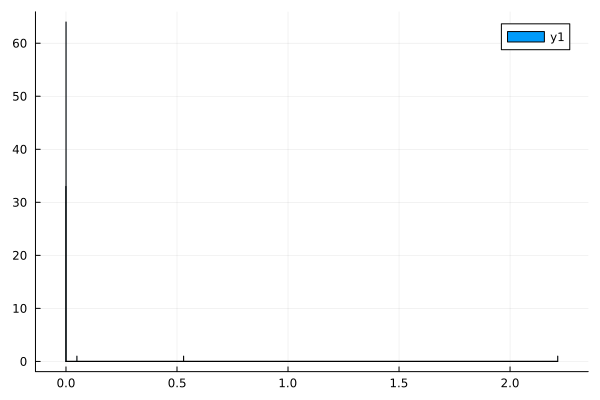

In [56]:
histogram(res_eq1["solar_gw"]*dfclust.solar_cap-res_eq1["quantity"][:,7])